# Visualising RDMs with the 92 images dataset

This notebook demonstrates how `rsatoolbox.vis.show_rdm` can be used to visualise RDMs. By setting the RDM's pattern_descriptors to `rsatoolbox.vis.Icon` instances it is possible to automatically generate stacked image labels and other custom visualisations.

In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib
from rsatoolbox import vis
from rsatoolbox import rdm
import numpy as np
import os
import inspect
import scipy.io
from collections import defaultdict

## Loading data and building RDMs instance with Icon pattern_descriptors
Before we begin, we need to load up the fMRI data from the 92 images dataset (Kriegeskorte et al., 2008).

In [2]:
# supporting functions and constants
DEMO_DIR = os.getcwd()
NEURON_DIR = os.path.join(DEMO_DIR, "rsatoolbox_demos/92imageData")


def neuron_2008_icons(**kwarg):
    """ Load Krigeskorte et al. (2008, Neuron) images as Icon instances."""
    mat_path = os.path.join(NEURON_DIR, "Kriegeskorte_Neuron2008_supplementalData.mat")
    mat = scipy.io.loadmat(mat_path)
    colors = plt.get_cmap('Accent', lut=16).colors
    markers = list(matplotlib.markers.MarkerStyle('').markers.keys())
    icons = defaultdict(list)
    for this_struct in mat["stimuli_92objs"][0]:
        # we're going to treat the 4 binary indicators (human, face, animal, natural) as a
        # base2 binary string, and index into this array of colors accordingly.
        index = int("".join(
                     [
                         str(this_struct[this_key][0,0]) for this_key in (
                     'human', 'face', 'animal', 'natural')
                     ]
                 ),
                                  base=2)
        this_color = colors[index]
        icons['image'].append(vis.Icon(image=this_struct['image'],
                                       color=this_color,
                                       circ_cut='cut',
                                       border_type='conv',
                                       border_width=5,
                                       **kwarg))
        icons['string'].append(vis.Icon(string=this_struct['category'][0],
                                        color=this_color,
                                        font_color=this_color,
                                        **kwarg))
        icons['marker'].append(vis.Icon(marker=markers[index],
                                       color=this_color,
                                       **kwarg))
    return icons


def neuron_2008_rdms_fmri(**kwarg):
    """ Load Kriegeskorte et al. (2008, Neuron) fMRI RDMs as RDMs instance.
    All key-word arguments are passed to neuron_2008_images."""
    mat_path = os.path.join(NEURON_DIR, "92_brainRDMs.mat")
    mat = scipy.io.loadmat(mat_path)
    icons = neuron_2008_icons(**kwarg)
    # insert leading dim to conform with rsatoolbox nrdm x ncon x ncon convention
    return rdm.concat(
        [
            rdm.RDMs(
                dissimilarities=this_rdm["RDM"][None, :, :],
                dissimilarity_measure="1-rho",
                rdm_descriptors=dict(
                    zip(["ROI", "subject", "session"], this_rdm["name"][0].split(" | ")),
                    name=this_rdm["name"][0]
                ),
                pattern_descriptors=icons
            )
            for this_rdm in mat["RDMs"].flatten()
        ]
    )

In [3]:
# as an example, load the Kriegeskorte et al., 2008 fMRI RDMs
rdms = neuron_2008_rdms_fmri()

## Plotting RDMs with text labels

In [4]:
# to keep it simple, let's start with plotting the first 10 conditions 
rdms_small = rdms.subset_pattern('index', np.arange(10))
rdms_small = rdm.rank_transform(rdms_small)
rdms_small.dissimilarity_measure += " (ranks)"

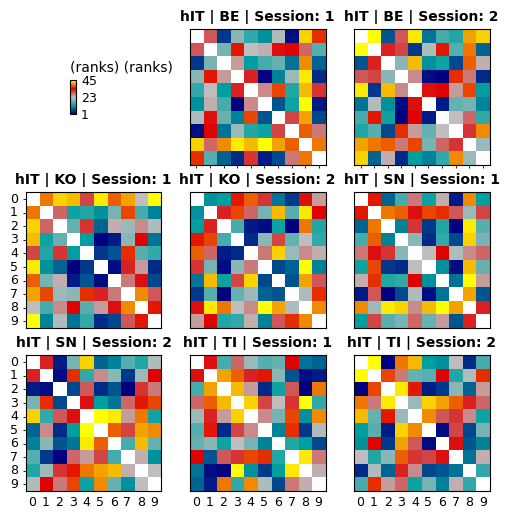

In [5]:
vis.show_rdm(rdms_small, show_colorbar='figure', cmap='classic',
             rdm_descriptor='name', pattern_descriptor='index')
None

## Plotting with image labels
It might help to put some image labels on...

In [6]:
vis.show_rdm(rdms_small, show_colorbar='figure', cmap='classic',
             rdm_descriptor='name', pattern_descriptor='image')
None

Notice how the image labels are scaled to avoid overlap. However, they are rather small. Grouping them might help us get away with larger images. We will also tweak `icon_spacing` to 10% overlap between the images.

In [7]:
vis.show_rdm(rdms_small, show_colorbar='figure', cmap='classic',
             rdm_descriptor='name', pattern_descriptor='image',
            num_pattern_groups=5, icon_spacing=.9)
None

Now the images are very clear (maybe too big in fact, unless you are preparing a figure for a slideshow). Notice how `show_rdm` adds white gridlines to mark the label groups. If you like, you can control this behavior with the `gridlines` argument.

For now though, let's scale up to the full insanity of 92 images...

In [8]:
# probably sane not to plot too many of these
fig, ax, ret_val = vis.show_rdm(rdms[0],
             show_colorbar='panel', cmap='classic',
             rdm_descriptor='name', pattern_descriptor='image',
             num_pattern_groups=6, icon_spacing=.9,
             vmin=0., n_column=1, figsize=(10,10)
            )

Not too bad, considering how many images we are plotting. With this full view you can also see two other features that help guide the eye in large RDM visualisations:
* A carefully selected `num_pattern_groups` parameter really helps with picking out interesting conditions (notice how the faces are in grids 3-4 and 7-8 above).
* The `color` parameter that was used when instancing the Icons controls the color of the supporting lines and the circular outlines. This can also be used to convey category membership.

## Optimising image label display and saving figure
In general, you can achieve larger, clearer image labels by
* plotting fewer RDMs in the same figure
* increasing `num_pattern_groups`
* decreasing `icon_spacing`
* adjusting `figsize`
* increasing `dpi` when saving, see below

In [9]:
# to save the figure, remember to set bbox_inches='tight'.
# (Otherwise the image labels may get cropped out)
fig.savefig('temp_rdm.png', bbox_inches='tight', dpi=300)

The saved RDM image is plotted below. It may look quite a bit crisper than the inline view we generated previously.
![rdm image](temp_rdm.png)

## Plot MDS

Here we make a scatterplot of the RDM reduced to two dimensions using MultiDimensional Scaling

In [10]:
fig=vis.show_MDS(
    rdms[0],
    rdm_descriptor='name',
    pattern_descriptor='image', 
    icon_size=0.2, 
)
None
fig.set_size_inches(10,10)